# Draws static version of tree from Nextstrain JSON
This notebook uses a locally downloaded version of the [baltic](https://github.com/evogytis/baltic) module that has been manually edited to fix [this bug](https://github.com/evogytis/baltic/issues/38).

In [1]:
import collections

import baltic

import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.ticker

import mpl_toolkits.axes_grid1.inset_locator

In [2]:
# Read trees

tree_jsons = {
    "lineage A + C29095T root": "../auspice/early-SARS2-trees_crits-christoph2024-Feb-15-2020-lineage-A-C29095T-colormuts.json",
    "lineage A root": "../auspice/early-SARS2-trees_crits-christoph2024-Feb-15-2020-lineage-A-colormuts.json",
}

trees = {
    tree: baltic.loadJSON(json_path, json_translation={"name": "name", "length": "divergence"})[0]
    for (tree, json_path) in tree_jsons.items()
}


Tree height: 0.001450
Tree length: 0.148210

Numbers of objects in tree: 1027 (166 nodes and 861 leaves)


Tree height: 0.001320
Tree length: 0.117970

Numbers of objects in tree: 1025 (164 nodes and 861 leaves)



In [3]:
# fill the 'haplotype_8782_28144' trait which is used for coloring
# this is ad hoc and is not guaranteed to work for arbitrary trees,
# but will work for these

def fill_parents(n, trait, traitval):
    if not n.is_leaf():
        n.traits[trait] = traitval
    if n.parent:
        fill_parents(n.parent, trait, traitval)

def fill_trait(tree, trait="haplotype_8782_28144"):
    # first make everything lacking trait 'CT (lineage B)'
    for n in tree.Objects:
        if (trait not in n.traits) and (not n.is_leaf()):
            assert not n.is_leaf()
            n.traits[trait] = "CT (lineage B)"
    # now make all ancestors of 'TT (A-B intermediate)' that trait
    for n in tree.getExternal():
        if n.is_leaf() and (n.traits[trait] == "TT (A-B intermediate)"):
            fill_parents(n, trait,  "TT (A-B intermediate)")
    # now make all ancestors of 'TC (lineage A)' that trait
    for n in tree.getExternal():
        if n.is_leaf() and (n.traits[trait] == "TC (lineage A)"):
            fill_parents(n, trait,  "TC (lineage A)")

for tree in trees.values():
    fill_trait(tree)

tip_color_attr='mutations_from_recCA', min_tip_color_attr=377, max_tip_color_attr=388
tip_shape_vals=['other', '2020 market environment', '2019 non-market sequence', '2019 market sequence'], tip_shape_markers=['o', 'h', 'D', 's']
branch_color_attr='haplotype_8782_28144', branch_color_vals={'CT (lineage B)', 'TC (lineage A)', 'TT (A-B intermediate)'}


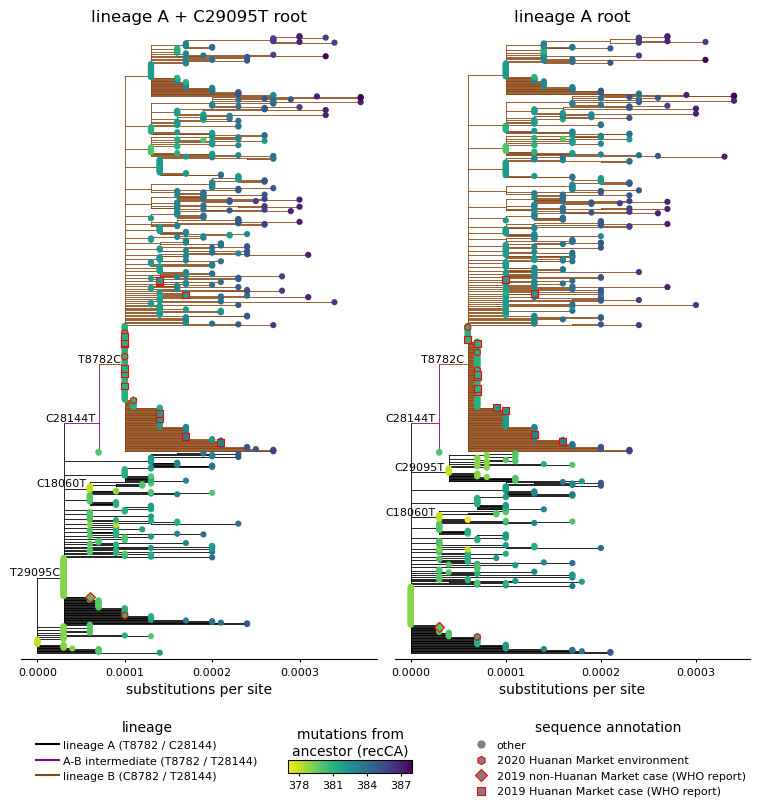

In [4]:
# draw tree

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(trees),
    sharex=False,
    sharey=False,
    figsize=(3.75 * len(trees), 8),
    constrained_layout=True,
    facecolor="w",
)

# color tip nodes
tip_color_attr = "mutations_from_recCA"
min_tip_color_attr = min(
    n.traits[tip_color_attr] for tree in trees.values() for n in tree.getExternal()
)
max_tip_color_attr = max(
    n.traits[tip_color_attr] for tree in trees.values() for n in tree.getExternal()
)
print(f"{tip_color_attr=}, {min_tip_color_attr=}, {max_tip_color_attr=}")
tip_color_norm = matplotlib.colors.Normalize(
    vmin=min_tip_color_attr, vmax=max_tip_color_attr
)
tip_color_cmap = matplotlib.colormaps.get_cmap("viridis_r")
# --- create a tiny axes *inside* ax and drop a colour-bar in it ----------
cax = mpl_toolkits.axes_grid1.inset_locator.inset_axes(
    axes[0],
    width="35%",           # 3 % of the parent axes’ width
    height="2%",         # 45 % of the parent axes’ height
    loc="lower left",     # any of: upper/lower {left, right, centre}
    bbox_to_anchor=(0.75, -0.18, 1, 1),
    bbox_transform=axes[0].transAxes,
    borderpad=0,
 )
sm = matplotlib.cm.ScalarMappable(norm=tip_color_norm, cmap=tip_color_cmap)
sm.set_array([])  # dummy data so MPL is happy
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cax.set_xlabel("mutations from\nancestor (recCA)", fontsize=10)
cbar.ax.xaxis.set_label_position('top')
cax.tick_params(
    which="both",        # major and (if present) minor ticks
    length=2,            # shorter tick marks
    width=0.8,           # thinner tick lines
    labelsize=8,         # smaller tick-label font
)
cbar.locator = matplotlib.ticker.MaxNLocator(nbins=4, prune=None)
cbar.update_ticks()

def color_tips(node):
    if node.is_leaf():
        return tip_color_cmap(tip_color_norm(node.traits[tip_color_attr]))

# tip shape
tip_shape_attr = "addtl_annotations"
tip_renames = {
    "other": "other",
    "2020 market environment": "2020 Huanan Market environment",
    "2019 market sequence": "2019 Huanan Market case (WHO report)",
    "2019 non-market sequence": "2019 non-Huanan Market case (WHO report)",
}
tip_shape_markers = ["o", "h", "D", "s"]
tip_sizes = [20, 25, 25, 25]
tip_edgecolors = ["none", "red", "red", "red"]
tip_linewidths = [0, 0.8, 0.8, 0.8]
tip_zorders = [3, 4, 5, 6] 
tip_shape_vals = list(reversed(sorted(set(
    n.traits[tip_shape_attr] for tree in trees.values() for n in tree.getExternal())
)))
print(f"{tip_shape_vals=}, {tip_shape_markers=}")
tip_handles = [
    matplotlib.lines.Line2D(
        [], [], marker=m, label=tip_renames[name], linestyle="none", color="gray", markeredgecolor=ec, markeredgewidth=lw
    )
    for (m, ec, lw, name) in zip(
        tip_shape_markers, tip_edgecolors, tip_linewidths, tip_shape_vals
    )
]
tip_leg = axes[1].legend(
    handles=tip_handles,
    title='sequence annotation',        # optional legend title
    loc="upper left",
    bbox_to_anchor=(0.2, -0.09),   # fine-tune anchor position
    frameon=False,              # no box around legend
    handletextpad=0.4,          # shrink gap marker↔text
    borderaxespad=0,            # gap legend↔axes edge
    fontsize=8,
    title_fontsize=10,
)

# branch colors
branch_color_attr = "haplotype_8782_28144"
branch_color_vals = set(n.traits[branch_color_attr] for tree in trees.values() for n in tree.getExternal())
print(f"{branch_color_attr=}, {branch_color_vals=}")
branch_colors = {
    "TC (lineage A)": "black",
    "TT (A-B intermediate)": "darkmagenta",
    "CT (lineage B)": "saddlebrown",
}
relabel_branch_legend = {
    "TC (lineage A)": "lineage A (T8782 / C28144)",
    "TT (A-B intermediate)": "A-B intermediate (T8782 / T28144)",
    "CT (lineage B)": "lineage B (C8782 / T28144)",
}
def color_branches(node):
    n = node
    while branch_color_attr not in n.traits:
        n = n.parent
        if n is None:
            return "purple"
    return branch_colors[n.traits[branch_color_attr]]
branch_handles = [
    matplotlib.lines.Line2D(
        [], [], marker="none", label=relabel_branch_legend[name], color=color
    )
    for (name, color) in branch_colors.items()
]
branch_leg = axes[0].legend(
    handles=branch_handles,
    title='lineage',        # optional legend title
    loc="upper left",
    bbox_to_anchor=(0.03, -0.09),   # fine-tune anchor position
    frameon=False,              # no box around legend
    handletextpad=0.4,          # shrink gap marker↔text
    borderaxespad=0,            # gap legend↔axes edge
    fontsize=8,
    title_fontsize=10,
)

# branch mutation-labeling function
def label_mut_of_interest(node):
    """Returns mutation if non-tip node w mutations of interest, otherwise False."""
    muts_to_label = [
        "C29095T", "T29095C",
        "T18060C", "C18060T",
        "T8782C", "C8782T",
        "T28144C", "C28144T",
    ]
    if node.is_leaf():
        return False
    try:
        muts = node.traits["branch_attrs"]["labels"]["mutations"]
        if any(m in muts for m in muts_to_label):
            return muts
    except KeyError:
        pass
    return False

tree = list(trees.values())[0]
ax = axes[0]
for (treename, tree), ax in zip(trees.items(), axes):

    ax.set_title(treename)

    tree.plotTree(
        ax=ax,
        x_attr=lambda k: k.length,
        width=0.6,
        colour=color_branches,
    )

    tree.addText(
        ax=ax,
        x_attr=lambda k: k.length - 4e-6,
        target=lambda k: label_mut_of_interest(k) is not False,
        text=label_mut_of_interest,
        va="bottom",
        ha="right",
        size=8,
        color="black",
        zorder=5,
    )
    
    for attr, m, s, ec, lw, zo in zip(
        tip_shape_vals,
        tip_shape_markers,
        tip_sizes,
        tip_edgecolors,
        tip_linewidths,
        tip_zorders,
        strict=True,
    ):
        tree.plotPoints(
            ax=ax,
            marker=m,
            x_attr=lambda k: k.length,
            colour=color_tips,
            edgecolor=ec,
            linewidth=lw,
            outline=False,
            size=s,
            zorder=zo,
            alpha=1,
            target=lambda k: k.is_leaf() and k.traits[tip_shape_attr] == attr,
        )
    
    ax.plot()
    
    _ = ax.set_ylim(-0.01 * tree.ySpan, tree.ySpan * 1.01)
    ax.invert_yaxis()
    
    # Hide the *y*-axis completely
    ax.spines["left"].set_visible(False)      # no left frame line
    ax.spines["right"].set_visible(False)     # (redundant for most 2-D plots)
    ax.tick_params(axis="y",                  # suppress ticks & labels
                   which="both",              # major + minor
                   left=False, right=False,
                   labelleft=False)
    
    # Keep the bottom x-axis, remove the top one
    ax.spines["top"].set_visible(False)       # frame line
    ax.tick_params(axis="x",
                   which="both",
                   top=False)                 # ticks / labels only at bottom
    
    
    ax.tick_params(
            which="both",        # major and (if present) minor ticks
            length=2,            # shorter tick marks
            width=0.8,           # thinner tick lines
            labelsize=8,         # smaller tick-label font
    )
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=4, prune=None))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.0001))
    ax.set_xlabel("substitutions per site", fontsize=10)

fig.savefig("tree.pdf")